# Predicting Crash Severity on City Streets of Chicago

Traffic crashes are one of the leading causes of death in the US. Each year, tens of thousands of women and men are killed or injured in traffic accidents. In Chicago for example, more than 2,000 people were killed or seriously injured in 2016 traffic crashes, with an average of five people seriously injured each day and one person killed every three days. City departments are continually making efforts to improve roadway safety and to reduce fatalities and serious injuries. One of these efforts is based on data-driven models that aim to understand the factors and causes of traffic collisions, and reveal any pattern or trend from past accidents. 

The city of Chicago has made available Online, through its [portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if), a description of the crashes that occurred within the city. The data contains information about each traffic crash on city streets of Chicago from 2015 to present, including the time and location of the crash, weather, road and lighting conditions, type of crash and its primary cause, injuries and damage, etc. The data also specifies whether the crash produced injuries or not. By looking into this dataset, we aim at exploring the circumstances and conditions of the crashes that led to injuries, and building a model that predicts crash severity.

The city of Chicago can use the model to understand the leading factors of a severity of a crash and to identify any risky driving behaviors. In this way, the model can help them decide on whether to improve the infrastructure, to incorporate more safety features on the roads or to develop better traffic control policies. 

This report is divided as follows. We first describe the data and focus on cleaning it to make it ready for crash severity analysis. In particular, we explain how we handled the presence of missing values and outliers that could have occurred in the data due to human errors. After we clean the data of Chicago crashes, we visually and statistically explore the information provided by the data, to see how the conditions of a crash change according to its severity and to examine if there is any pattern in the occurrence of Chicago crashes. 

## Data Wrangling

We obtained the data from Chicago city online [portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if) that we load here.   

In [1]:
import pandas as pd

# A csv file of Chicago crashes was downloaded on September 24, 2019 from
# https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

# Read the file and save the data as crashes dataframe
crashes = pd.read_csv('DataCleaning/Traffic_Crashes.csv')

The data consists of redundant columns, outliers and missing values that we first need to address.

### First Step: Removing Redundant Columns

We first remove all irrelevant and mostly empty columns.

In [2]:
# First remove irrelevant or mostly-empty columns

crashes = crashes.drop(
    columns=['CRASH_DATE_EST_I', 'LANE_CNT', 'ROAD_DEFECT', 'REPORT_TYPE',
             'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I',
             'DATE_POLICE_NOTIFIED', 'SEC_CONTRIBUTORY_CAUSE', 'PHOTOS_TAKEN_I',
             'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE',
             'WORKERS_PRESENT_I', 'LOCATION'])

The data now consists of the following columns:

In [3]:
print(crashes.columns)

Index(['RD_NO', 'CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
       'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'CRASH_TYPE', 'DAMAGE',
       'PRIM_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'MOST_SEVERE_INJURY',
       'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
       'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
       'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE'],
      dtype='object')


These columns provide various information about each crash of Chicago city:

1. Identification number of the crash (RD_NO);
2. Location information: street number, direction and name, beat of occurrence, latitude and longitude of the crash location;
3. Time information: the date, month, hour, and day of the week of the crash; 
4. Crash description and conditions: posted speed limit, traffic control device and its condition, weather condition, lighting condition, first collision type, traffic-way type, roadway surface condition, alignment of the road, primary contributory causes;
5. Crash damage and injuries: crash type (1- no injury/drive away or 2- injury or/and tow due to crash), damage cost in dollars, type of the most severe injury.

Some of these columns contain some missing or unknown entries and some outliers. The strategies we followed to deal with missing entries are either deducing their values from the available data or leaving them as an 'unknown/other' category. The latter strategy was followed to avoid removing the corresponding rows of the missing entries and thus to avoid losing any possible information from other columns, especially when there is a large number of unknown entries. We next describe what entries we were able to fill and what entries we left as an additional category.

### Second Step: Filling the missing entries

We describe how we filled some of the missing entries.

- **Posted Speed Limit**: This column indicates the posted speed limit (in miles per hour (MPH)) for the crash location. By checking the values of this column, we notice that some values are 0 or 99, which are considered as unreasonable numbers for the speed limit. To replace these values with reasonable ones, we first checked the column of the traffic-way type, which clarifies the location type of the crash (parking lot, driveway, alley, divided or undivided highway, ...). If the location of the crash is a parking lot, driveway or alley, we adjusted the speed limit to 15 MPH. On the other hand, by checking the name of the street, if the street is a highway or expressway, we adjusted the speed limit to 55 MPH. The remaining streets are assumed to have 30 MPH as speed limit (30 MPH is the speed limit of the most city streets of Chicago and it represents the maximum speed limit when there is no posted speed limit). We then regrouped the speeds into the following values: 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65 and 70. This is because there were some values in between these numbers (18, 23, 36, ...) which are not considered as common posted speed limits and which we believe are caused because of human errors.

In [4]:
# Posted speed limit
# This column contains a lot of inconsistencies, which we try to fix here

# check if the location of the crash is a parking lot, alley or driveway,
# then the speed limit should be 15 mph
crashes.loc[crashes.TRAFFICWAY_TYPE.isin(['PARKING LOT', 'ALLEY', 'DRIVEWAY']),
            'POSTED_SPEED_LIMIT'] = 15

# this is a list of of substrings that are contained in the names of
# Chicago streets where the speed limit is at least 55 mph
list_roads = ['SKYWAY', 'SHORE', '95TH', 'EXPY', 'XPY', 'DAN RYAN',
              'XPRS', 'CICERO', 'ROOSEVELT', 'INDIANAPOLIS', 'IRVING',
              'DAN RYAN', '98TH PL', 'FETRIDGE', 'MANNHEIM', 'WENTWORTH']

# some posted speed limits are 0, 99 and less than 10 mph which
# are unreasonable values find where the speed is unreasonable
is_spd_unreasonable = (crashes.POSTED_SPEED_LIMIT < 10) | (
    crashes.POSTED_SPEED_LIMIT == 99)

# check which street is possibly a highway
is_highwy = crashes.STREET_NAME.str.contains(list_roads[0])
for road in list_roads[1:]:
    is_highwy = is_highwy | (crashes.STREET_NAME.str.contains(road))

# adjust the unreasonable speed to 55mph if it is a highway
crashes.loc[(is_spd_unreasonable & is_highwy), 'POSTED_SPEED_LIMIT'] = 55

# otherwise, assume the street as normal one with 30 mph as speed limit
crashes.loc[crashes.POSTED_SPEED_LIMIT < 10, 'POSTED_SPEED_LIMIT'] = 30
crashes.loc[crashes.POSTED_SPEED_LIMIT == 99, 'POSTED_SPEED_LIMIT'] = 30

# some speed limits were high for normal streets, adjust them here
crashes.loc[((~is_highwy) & (crashes.POSTED_SPEED_LIMIT >= 50)),
            'POSTED_SPEED_LIMIT'] = 30

# regroup the speeds into 15,20,25,30,35,40,45,50,55,60,65
# to round up any in between value
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 10) & (
    crashes.POSTED_SPEED_LIMIT < 15), 'POSTED_SPEED_LIMIT'] = 15
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 15) & (
    crashes.POSTED_SPEED_LIMIT < 20), 'POSTED_SPEED_LIMIT'] = 20
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 20) & (
    crashes.POSTED_SPEED_LIMIT < 25), 'POSTED_SPEED_LIMIT'] = 25
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 25) & (
    crashes.POSTED_SPEED_LIMIT < 30), 'POSTED_SPEED_LIMIT'] = 30
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 30) & (
    crashes.POSTED_SPEED_LIMIT < 35), 'POSTED_SPEED_LIMIT'] = 35
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 35) & (
    crashes.POSTED_SPEED_LIMIT < 40), 'POSTED_SPEED_LIMIT'] = 40
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 40) & (
    crashes.POSTED_SPEED_LIMIT < 45), 'POSTED_SPEED_LIMIT'] = 45
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 45) & (
    crashes.POSTED_SPEED_LIMIT < 50), 'POSTED_SPEED_LIMIT'] = 50
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 50) & (
    crashes.POSTED_SPEED_LIMIT < 55), 'POSTED_SPEED_LIMIT'] = 55
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 55) & (
    crashes.POSTED_SPEED_LIMIT < 60), 'POSTED_SPEED_LIMIT'] = 60
crashes.loc[(crashes.POSTED_SPEED_LIMIT > 60) & (
    crashes.POSTED_SPEED_LIMIT < 65), 'POSTED_SPEED_LIMIT'] = 65

In [5]:
# Check the entries of speed limit
print(crashes.POSTED_SPEED_LIMIT.value_counts().sort_index())

10      1079
15     35662
20     11028
25     19284
30    246607
35     22446
40      3078
45      2013
50        44
55       657
60        13
65         5
70         1
Name: POSTED_SPEED_LIMIT, dtype: int64


- **Weather Condition**: The possible weather conditions reported at the time of the crash include: rain, clear, ice, snow, wind, ... The unknown entries of this column were deduced from the date and time of the crash. More specifically, by checking the reported weather conditions of other crashes that happened during the same day, the unknown weather condition of the same day crash was filled accordingly. If more than weather conditions were reported for the same day, we took the most common weather condition. Only three crashes with unknown weather conditions remained unknown, as no other crashes happened during the same day. Since the total number of crashes is around 340k, 3 crashes represent a tiny percentage of the whole data, therefore we removed the three rows with unknown weather conditions.

In [6]:
# Weather Conditions

crashes.CRASH_DATE = pd.to_datetime(crashes.CRASH_DATE)
crashes = crashes.set_index('RD_NO')

# find wich entries has unknown weather conditions and
# which entries has known weather conditions
is_unknown = (crashes.WEATHER_CONDITION == 'UNKNOWN') | (
    crashes.WEATHER_CONDITION == 'OTHER')
subset = crashes.loc[is_unknown, ['CRASH_DATE', 'WEATHER_CONDITION']]
subset2 = crashes.loc[~is_unknown, ['CRASH_DATE', 'WEATHER_CONDITION']]

# normalize the date to remove hours
subset['DAY'] = subset.CRASH_DATE.dt.normalize()
subset2['DAY'] = subset2.CRASH_DATE.dt.normalize()

# build a table with days and the dominant weather condition
# for each day from the data with known weather conditions
d = subset2.groupby('DAY')['WEATHER_CONDITION'].value_counts()
d = d.unstack()
table = d.idxmax(axis=1)

# fill the unknwon weather conditions usign the table that we
# just created
for index, row in subset.iterrows():
    if (row['DAY'] in table.keys()):
        crashes.at[index, 'WEATHER_CONDITION'] = table[row['DAY']]

# three entries were left unknow, we remove their corresponding rows
still_unknown = (crashes.WEATHER_CONDITION == 'UNKNOWN')
crashes = crashes.drop(index=crashes.index[still_unknown])

print(crashes.WEATHER_CONDITION.value_counts())

CLEAR                     285456
RAIN                       32222
SNOW                       12563
CLOUDY/OVERCAST            10336
FOG/SMOKE/HAZE               640
SLEET/HAIL                   556
SEVERE CROSS WIND GATE        75
FREEZING RAIN/DRIZZLE         64
BLOWING SNOW                   2
Name: WEATHER_CONDITION, dtype: int64


- **Lighting Condition**: The possible lighting conditions are: daylight, darkness, dusk, dawn. The unknown entries for this column were deduced from the time and month of the crash.

In [7]:
# Lighting Conditions

# define a function that takes the hour and the month of a day and return: 
# dusk, dawn, daylight or darkness accordingly


def mapToLight(hour, month):
    if ((hour == 5 & month in ([8, 7, 4])) | (hour == 4 & month in ([5, 6])) | 
        (hour == 6 & month in ([1, 2, 3, 9, 10, 11, 12]))):
        return 'DAWN'
    if ((hour < 19 & month in ([8, 7, 4, 3, 2, 9])) | (hour < 20 & month in ([5, 6]))
            | (hour < 18 & month == 10) | (hour < 16 & month in ([1, 11, 12]))):
        return 'DAYLIGHT'
    if ((hour == 19 & month in ([8, 7, 4, 3, 2, 9])) | (hour == 20 & month in ([5, 6]))
            | (hour == 16 & month in ([1, 12, 11])) | (hour == 18 & month == 10)):
        return 'DUSK'
    else:
        return 'DARKNESS'


# fill the unkown entries for ligting condition using the defined function mapToLight
noLight = crashes.loc[(crashes.LIGHTING_CONDITION == 'UNKNOWN'), [
    'CRASH_HOUR', 'CRASH_MONTH']]

for index, row in noLight.iterrows():
    crashes.at[index, 'LIGHTING_CONDITION'] = mapToLight(
        row.CRASH_HOUR, row.CRASH_MONTH)

In [8]:
print(crashes.LIGHTING_CONDITION.value_counts())

DAYLIGHT                  227955
DARKNESS, LIGHTED ROAD     68927
DARKNESS                   28650
DUSK                       10471
DAWN                        5911
Name: LIGHTING_CONDITION, dtype: int64


- **Roadway Surface Condition**: The possible road conditions include: dry, wet, snow or ice, etc... The unknown entries for this column were deduced from the weather condition of the crash. More specifically, if the weather condition is 'rain', the road condition is set to 'wet'. If the weather condition is 'snow' or 'sleet/hail', the road condition is set to 'snow or slush'. If the weather condition is 'freezing rain', the road condition is set to 'ice'. Otherwise, the road condition is set to 'dry'.

In [9]:
# Roadway surface

# fill the unkown road surface according to the weather conditions
crashes.loc[crashes.ROADWAY_SURFACE_COND.isin(['UNKNOWN', 'OTHER']) & 
            crashes.WEATHER_CONDITION.isin(['RAIN']),
            'ROADWAY_SURFACE_COND'] = 'WET'
crashes.loc[crashes.ROADWAY_SURFACE_COND.isin(['UNKNOWN', 'OTHER']) & 
            crashes.WEATHER_CONDITION.isin(['SNOW']),
            'ROADWAY_SURFACE_COND'] = 'SNOW OR SLUSH'
crashes.loc[crashes.ROADWAY_SURFACE_COND.isin(['UNKNOWN', 'OTHER']) & 
            crashes.WEATHER_CONDITION.isin(['FREEZING RAIN/DRIZZLE']),
            'ROADWAY_SURFACE_COND'] = 'ICE'
crashes.loc[crashes.ROADWAY_SURFACE_COND.isin(['UNKNOWN', 'OTHER']) & 
            crashes.WEATHER_CONDITION.isin(['SLEET/HAIL']),
            'ROADWAY_SURFACE_COND'] = 'SNOW OR SLUSH'
crashes.loc[crashes.ROADWAY_SURFACE_COND.isin(['UNKNOWN', 'OTHER']),
            'ROADWAY_SURFACE_COND'] = 'DRY'

In [10]:
print(crashes.ROADWAY_SURFACE_COND.value_counts())

DRY                278571
WET                 48263
SNOW OR SLUSH       12457
ICE                  2448
SAND, MUD, DIRT       175
Name: ROADWAY_SURFACE_COND, dtype: int64


### Third Step: Dealing with remaining columns

We describe next the remaining columns with unknown entries which were not possible to be filled and which we preferred keeping as an additional category.

- **Traffic-way type**: This column describes the type of the street location where the crash happened: divided, not divided, one way, parking lot, alley, driveway, ramp, intersection, roundabout,.... However around 3.8k entries are reported as 'unknown' and 34 as 'not reported'. There is no available data for this type of information for the city streets of Chicago. For now, we leave them as an additional category for future deep analysis.

In [11]:
print(crashes.TRAFFICWAY_TYPE.value_counts())

NOT DIVIDED                        156114
DIVIDED - W/MEDIAN (NOT RAISED)     64249
ONE-WAY                             45510
PARKING LOT                         24991
DIVIDED - W/MEDIAN BARRIER          21082
OTHER                               10383
ALLEY                                5448
UNKNOWN                              3838
FOUR WAY                             3468
CENTER TURN LANE                     3169
DRIVEWAY                             1180
RAMP                                 1111
T-INTERSECTION                        735
UNKNOWN INTERSECTION TYPE             284
FIVE POINT, OR MORE                   105
Y-INTERSECTION                        100
TRAFFIC ROUTE                          84
NOT REPORTED                           34
ROUNDABOUT                             19
L-INTERSECTION                         10
Name: TRAFFICWAY_TYPE, dtype: int64


In [12]:
# group the unknown entries into one category
unknown = crashes.TRAFFICWAY_TYPE.isin(['NOT REPORTED'])
crashes.at[unknown, 'TRAFFICWAY_TYPE'] = 'UNKNOWN'

In [13]:
print(crashes.TRAFFICWAY_TYPE.value_counts())

NOT DIVIDED                        156114
DIVIDED - W/MEDIAN (NOT RAISED)     64249
ONE-WAY                             45510
PARKING LOT                         24991
DIVIDED - W/MEDIAN BARRIER          21082
OTHER                               10383
ALLEY                                5448
UNKNOWN                              3872
FOUR WAY                             3468
CENTER TURN LANE                     3169
DRIVEWAY                             1180
RAMP                                 1111
T-INTERSECTION                        735
UNKNOWN INTERSECTION TYPE             284
FIVE POINT, OR MORE                   105
Y-INTERSECTION                        100
TRAFFIC ROUTE                          84
ROUNDABOUT                             19
L-INTERSECTION                         10
Name: TRAFFICWAY_TYPE, dtype: int64


- **Traffic control device**: This column clarifies whether there was a traffic control device (traffic signal, stop sign, yield, railroad crossing, ...) or not at the crash location. However 10k entries are reported as 'unknown', which we also leave as an additional category. Moreover, we grouped the following categories: 'RAILROAD CROSSING GATE','OTHER RAILROAD CROSSING', 'RR CROSSING SIGN' as one category labeled as 'railroad crossing sign'. 
 **Device condition**: This column indicates whether the traffic control device was working or not (no control, functioning properly or improperly or not functioning). We first made sure that this column and the previous one (traffic control device) are consistent, so that they both show similar entries when there was no control device. In this column, 16k entries were reported as 'unknown'. We also leave these entries for future deep analysis.

In [14]:
# Traffic Control Device

# combine the different labels Railroad signs into one category
crashes.loc[
    crashes.TRAFFIC_CONTROL_DEVICE.isin([
        'RAILROAD CROSSING GATE', 'OTHER RAILROAD CROSSING', 'RR CROSSING SIGN']),
    'TRAFFIC_CONTROL_DEVICE'] = 'RAILROAD CROSSING SIGN'

# make the columns 'traffic control device' and 'device condition consistent
# fill the unknown entries of 'traffic control device' from the column 'device condition'
crashes.loc[(crashes.TRAFFIC_CONTROL_DEVICE == 'UNKNOWN') &
            (crashes.DEVICE_CONDITION == 'NO CONTROLS'),
            'TRAFFIC_CONTROL_DEVICE'] = 'NO CONTROLS'
crashes.loc[crashes.TRAFFIC_CONTROL_DEVICE ==
            'NO CONTROLS', 'DEVICE_CONDITION'] = 'NO CONTROLS'
crashes.loc[(crashes.DEVICE_CONDITION == 'NO CONTROLS') &
            (crashes.TRAFFIC_CONTROL_DEVICE != 'NO CONTROLS'),
            'DEVICE_CONDITION'] = 'FUNCTIONING PROPERLY'
crashes.loc[crashes.DEVICE_CONDITION.isin(
    ['UNKNOWN', 'MISSING']), 'DEVICE_CONDITION'] = 'UNKNOWN'

In [15]:
print(crashes.TRAFFIC_CONTROL_DEVICE.value_counts())

NO CONTROLS                 197823
TRAFFIC SIGNAL               95425
STOP SIGN/FLASHER            32972
UNKNOWN                      10608
OTHER                         1994
LANE USE MARKING              1224
YIELD                          475
RAILROAD CROSSING SIGN         329
OTHER REG. SIGN                306
OTHER WARNING SIGN             289
SCHOOL ZONE                    138
POLICE/FLAGMAN                 136
DELINEATORS                     82
PEDESTRIAN CROSSING SIGN        64
FLASHING CONTROL SIGNAL         31
NO PASSING                      10
BICYCLE CROSSING SIGN            8
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64


In [16]:
print(crashes.DEVICE_CONDITION.value_counts())

NO CONTROLS                 197823
FUNCTIONING PROPERLY        123296
UNKNOWN                      16122
OTHER                         2043
FUNCTIONING IMPROPERLY        1861
NOT FUNCTIONING                611
WORN REFLECTIVE MATERIAL       158
Name: DEVICE_CONDITION, dtype: int64


- **Primary contributory causes**: This column includes a lot of possible entries that describe the primary driver's behavior that led to the crash (improper backing, following too closely, improper turning, reckless driving,...). However, around one third of the entries (110K) are reported as 'unable to determine'. We also leave them for future analysis and to investigate if there is any type of driver's behavior that can lead to a severe crash.

In [17]:
print(crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts())

UNABLE TO DETERMINE                                                                 123201
FOLLOWING TOO CLOSELY                                                                38456
FAILING TO YIELD RIGHT-OF-WAY                                                        38367
NOT APPLICABLE                                                                       18596
IMPROPER OVERTAKING/PASSING                                                          16734
IMPROPER BACKING                                                                     15697
IMPROPER LANE USAGE                                                                  13938
FAILING TO REDUCE SPEED TO AVOID CRASH                                               13673
IMPROPER TURNING/NO SIGNAL                                                           11587
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  10793
DISREGARDING TRAFFIC SIGNALS                                                          5551

The remaining two columns of the third category: **alignment of the street** (straight, curve,...) and **first crash type** (angle, sideswipe, rear to rear, rear end,....) have no missing entries.

Since we will only focus on the type of crash (injuries or no injuries), we drop the columns that specify what types of injuries happened.

In [18]:
# droping some more columns that are not going to be used
crashes = crashes.drop(columns=['INJURIES_FATAL', 'INJURIES_INCAPACITATING',
                                'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
                                'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN'])

We also drop the rows where the location of the crash is not reported.

In [45]:
crashes = crashes[(crashes.LATITUDE.notnull())
                              & (crashes.LONGITUDE.notnull())]
crashes = crashes[(crashes.LATITUDE!=0)
                              & (crashes.LONGITUDE!=0)]

## Data Exploration

After having cleaned the data of Chicago crashes, we now explore the information provided by the data, to see how the conditions of a crash change according to its severity and to examine if there is any pattern in the occurrence of Chicago crashes.

The data consist of the following information for each crash: weather, road, and lighting conditions, posted speed limit, control device, road alignment, traffic-way type, time, location and contributory causes of each crash. Moreover, the crashes are divided into two types: 1-'INJURY AND / OR TOW DUE TO CRASH' and 2-'NO INJURY / DRIVE AWAY'. In the sequel and for brevity, we refer to the first crash type as 'injury' crashes and to the second crash type as 'no injury' crashes. Using this information, we address the following questions: how do the weather conditions contribute to the severity of the crash, and how can the road types, conditions and curvatures affect the crash severity? Do crashes with injury occur more in high speed streets or normal streets? What driving behaviors can lead to severe crashes? Is the presence of a control device limit the occurrence of crashes? Is there any time or day or season of the year where severe crashes are more likely to occur? How are the severe crashes spread across the city of Chicago? What places are more prone to severe crashes? 

In this section, we try to answer these questions by exploring the data as follows:
- For each crash feature or descriptor, we plot how each crash type is distributed across the different categories of the feature, in order to examine if there are any differences between the factors of 'injury' and 'no injury' crashes; 
- We also plot how each type of crash is changing over time and across the days of the week;
- We then statistically analyze the relationship between each crash feature and its type, to test for any significant association. 
- We finally show a map of Chicago with the locations of the two types of crashes. We show density plot of each crash type and we also show how the crashes are divided into the community areas of Chicago. We also study the statistical significance of the spatial patterns of the crashes on the map.

### Loading the Required Modules

We here import the required modules.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
import numpy as np
from scipy.stats import chi2_contingency
import geopandas as gpd
from shapely.geometry import Point
import geoplot as gplt
import geoplot.crs as gcrs

We define the following functions that we are going to use in the analysis. The first function sets the style for the bar plots and the second function plots the bar plots of each crash type given a specific feature. The third function computes Cramer's V (with bias correction) and contingency coefficients that indicate if there is any association between categorical variables and its strength.

In [23]:
# This function is to set the style for the bar plots

def style_set(axes):
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="both",
                       which="both",
                       bottom=False,
                       top=False,
                       labelbottom=False,
                       left=False,
                       right=False)
        ax.legend(frameon=False)
    axes[1].tick_params(labelleft=False)
    axes[1].set_ylabel("")
    axes[0].yaxis.label.set_fontsize(12)
    
    
def plot_percentages(data, colname, figsize):
    
    # get the feature(colname) counts for the 'injury' crash type
    injury = data.loc[data.CRASH_TYPE ==
                      'INJURY AND / OR TOW DUE TO CRASH', colname].value_counts()
    # compute the percentage for each category of the feature
    injury_percent = 100 * injury / sum(injury)
    injury_percent = injury_percent.reset_index()
    injury_percent.columns = [colname, 'Percentage']

    # get the feature counts for the 'no injury' crash type
    no_injury = data.loc[data.CRASH_TYPE == 'NO INJURY / DRIVE AWAY',
                         colname].value_counts()
    # compute the percentage for each speed limit
    no_injury_percent = 100 * no_injury / sum(no_injury)
    no_injury_percent = no_injury_percent.reset_index()
    no_injury_percent.columns = [colname, 'Percentage']

    if (colname in (["POSTED_SPEED_LIMIT", "CRASH_HOUR", "CRASH_MONTH"])):
        injury_percent.sort_values(colname, inplace=True)
        no_injury_percent.sort_values(colname, inplace=True)

    feature = pd.merge(injury_percent, no_injury_percent, how='outer',
                       on=colname, suffixes=('_injury', '_no_injury'))
    feature = feature.fillna(0)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    xl = max(max(injury_percent['Percentage']), max(no_injury_percent['Percentage']))
    feature.plot.barh(x=colname, y="Percentage_injury",
                      color="red", ax=axes[0], label='Injury',xlim=[0, xl])

    for i, v in enumerate(feature['Percentage_injury']):
        axes[0].text(v + 0.1, i - 0.1, str((v * 1000 // 1) /
                                           1000) + '%', color='black', fontweight='bold')

    feature.plot.barh(x=colname, y="Percentage_no_injury",
                      color="b", ax=axes[1], label='No Injury',xlim=[0, xl])

    for i, v in enumerate(feature['Percentage_no_injury']):
        axes[1].text(v + 0.1, i - 0.1, str((v * 1000 // 1) /
                                           1000) + '%', color='black', fontweight='bold')

    style_set(axes)
    axes[0].set_ylabel(colname.replace("_"," "))
    
# This function computes the Cramer's V coefficient
# Inputs: chi2: chi-square statistic, table: cross tabulated data
def cram_cont(chi2, table):
    ntot = table.sum().sum()
    nrow, ncol = table.shape
    phi_sqr = chi2/ntot
    phi_sqr_tilde = max(0, phi_sqr-(nrow-1)*(ncol-1)/(ntot-1))
    ncol_tilde = ncol-((ncol-1)**2)/((ntot-1))
    nrow_tilde = nrow-((nrow-1)**2)/((ntot-1))
    cramer = np.sqrt(phi_sqr_tilde/min(ncol_tilde-1, nrow_tilde-1))
    cont = np.sqrt(chi2/(chi2+ntot))
    return (cramer, cont)
    plt.show()

### Injury and No Injury Crashes Across the Features

We first check how each crash type differ across the features. For each feature, we plot the distribution of each crash type to see if there are any differences and what conditions can possibly lead to crashes with injuries. 

#### Posted Speed Limit
We start with the posted speed limit. We check how injury and no injury crashes are distributed across the possible values of posted speed limit, and see if the speed limit of the streets is associated with the type of crashes and at what speed limits crashes with injuries are more concentrated.

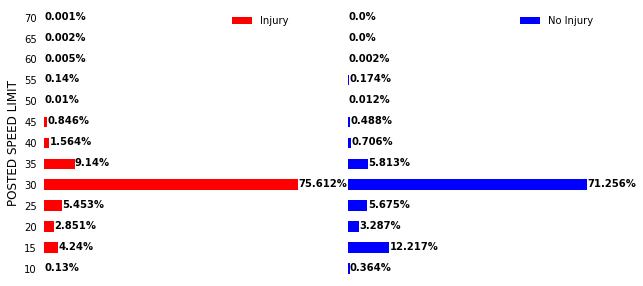

In [24]:
plot_percentages(crashes, "POSTED_SPEED_LIMIT", figsize=(10, 5))

We see from the plot how most of the crashes of either type correspond to a posted speed limit of 30 mph. This might be because most of Chicago streets have 30 mph as speed limit. We also see that with speeds of 35, 40 and 45 mph as well as 60, 65 and 70 mph, their proportions out of the injury crashes are slightly higher than those of no injury crashes. On the other hand, lower speeds of 10 and 15 mph have greater contribution in percentage to no injury crashes than to injury crashes.

#### Traffic Control Device
We now consider the presence of traffic control device at the location of the crash and check whether its presence can be related to the type of crash that occurred.

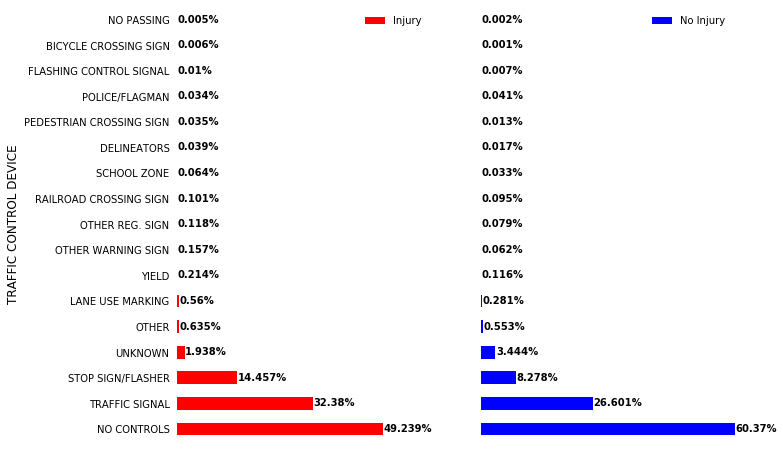

In [25]:
plot_percentages(crashes, "TRAFFIC_CONTROL_DEVICE", figsize=(10, 8))

We notice that for both types of crashes, most of the crashes happen when there was no control device. However, the proportions of the following two devices: traffic signal and the stop sign are greater with injury crashes than those of no injury crashes. This might be related to the fact that traffic signal and stop sign are present at intersection where severe crashes are more likely to occur.

#### Weather Conditions
We now consider the weather conditions for both types of crashes and check if any weather condition can be related to crashes with injury.

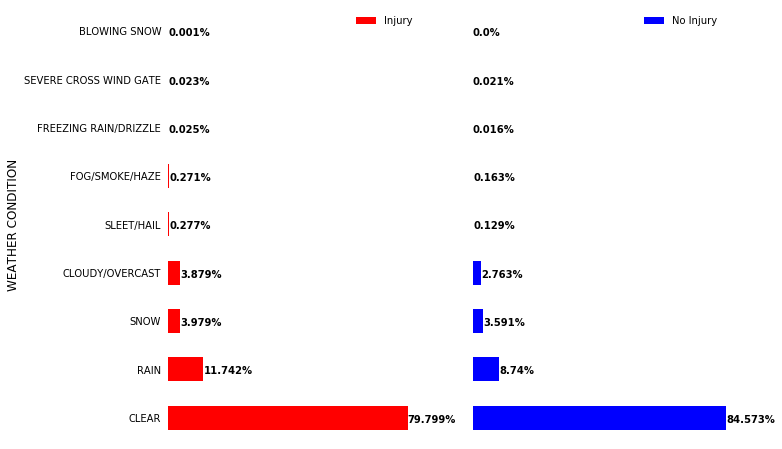

In [26]:
plot_percentages(crashes, "WEATHER_CONDITION", figsize=(10,8))

We see from the plots that most crashes, even the ones with injury, occurred when the weather was clear. This might suggest that people are more careful with their driving when the weather is not clear. However, we see that the proportions of the following weather conditions: rain, cloudy and sleet are slightly higher with injury crashes than with no injury crashes.

#### Lighting Conditions
We now check the lighting conditions, which describes how lighted the road was during the crash. It is interesting to know where crashes with injuries happened most compared to crashes with no injuries. 

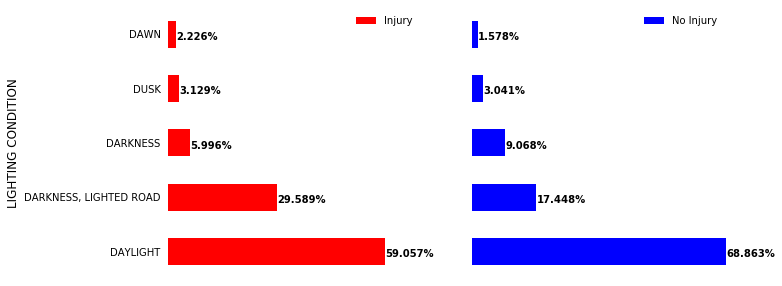

In [27]:
plot_percentages(crashes, "LIGHTING_CONDITION", figsize=(10,5))

We see that most of the crashes happened during daylight, which is expected because most of the commute time happen during the day. However, we see that the proportions of darkness with lighted road and dawn are higher with injury crashes. 

#### Road Alignment
We now check the crash type with respect to the road alignment, which specifies whether the road is aligned or curved. We here check at which road alignment, each crash type occurred.

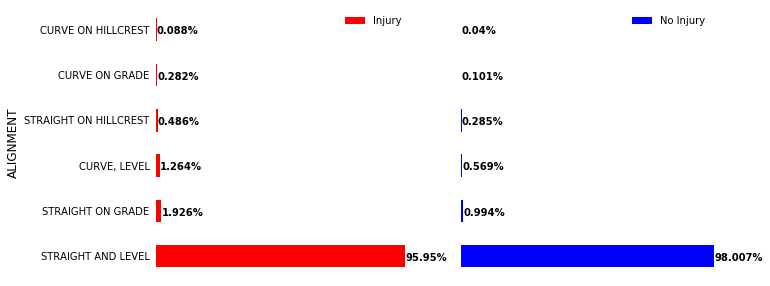

In [28]:
plot_percentages(crashes, "ALIGNMENT", figsize=(10, 5))

We notice that the majority of crashes of either type occurred on straight and level roads. However, we notice the proportions of other types of alignment of injury crashes are slightly higher than those with no injury crashes. This might be explained by the fact that most of Chicago streets are straight and level, which might suggest that his feature might not be helpful in determining the severity of a crash.

#### Road Surface Conditions
We now check the road conditions for each type of crash, and see how each crash type is distributed according to the road surface condition.

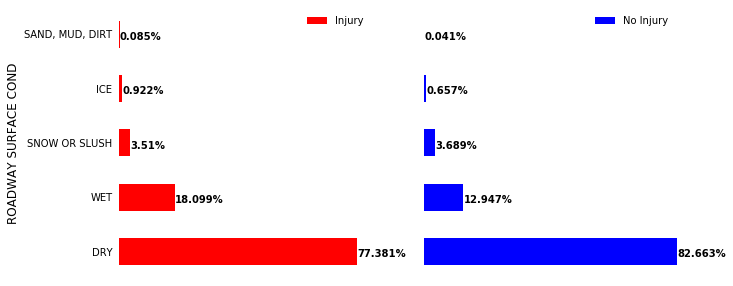

In [29]:
plot_percentages(crashes, 'ROADWAY_SURFACE_COND', figsize=(10, 5))

Similarly to weather conditions, we also notice here that most of the crashes happened on dry surface roads. However, the proportions of the following two conditions: wet and ice are higher with injury crashes.

#### First Collision Type
This feature specifies the type of collision that happened whether it was from the side or from the rear, etc. We now examine the crash type with respect to the collision type.

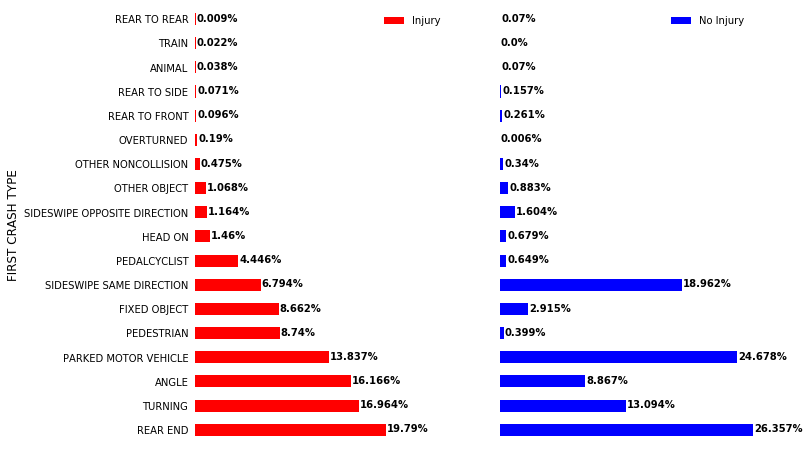

In [30]:
plot_percentages(crashes, "FIRST_CRASH_TYPE", figsize=(10, 8))

We immediately see for this feature, the noticeable difference in distribution of each crash type. In particular, we notice how turning, angle collision and collision with pedestrian or pedalcyclist or fixed object contribute more to crashes with injury. On the other hand, sideswipe collision and accidents with parked motor vehicle contribute less to crashes with injury.

#### Trafficway Type
We now check the trafficway type for each crash type. The trafficway type describes the type of street location of the crash. 

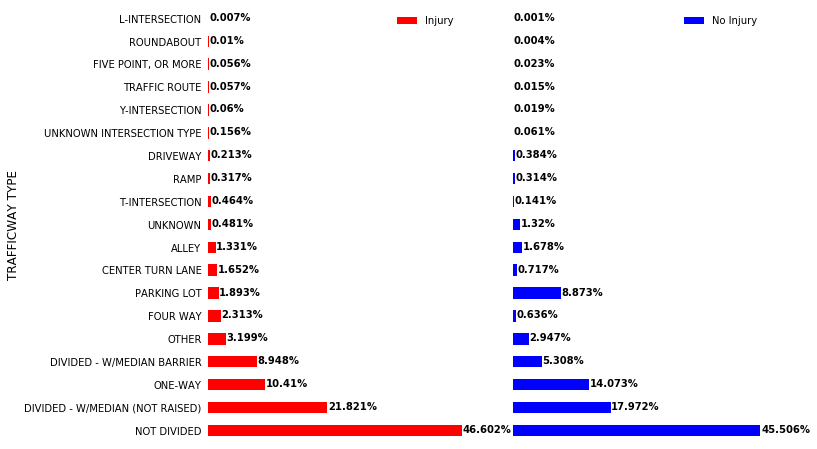

In [31]:
plot_percentages(crashes, "TRAFFICWAY_TYPE",figsize=(10,8))

While most of the crashes occurred in non divided road, we see higher proportions for divided roads, four way and center turn lane with injury crashes than with no injury crashes. Moreover, we notice that parking lot collisions contribute less to injury crashes. 

#### Contributory Causes
This feature describes the contributory cause of the crashes which includes driving behaviors or external conditions.

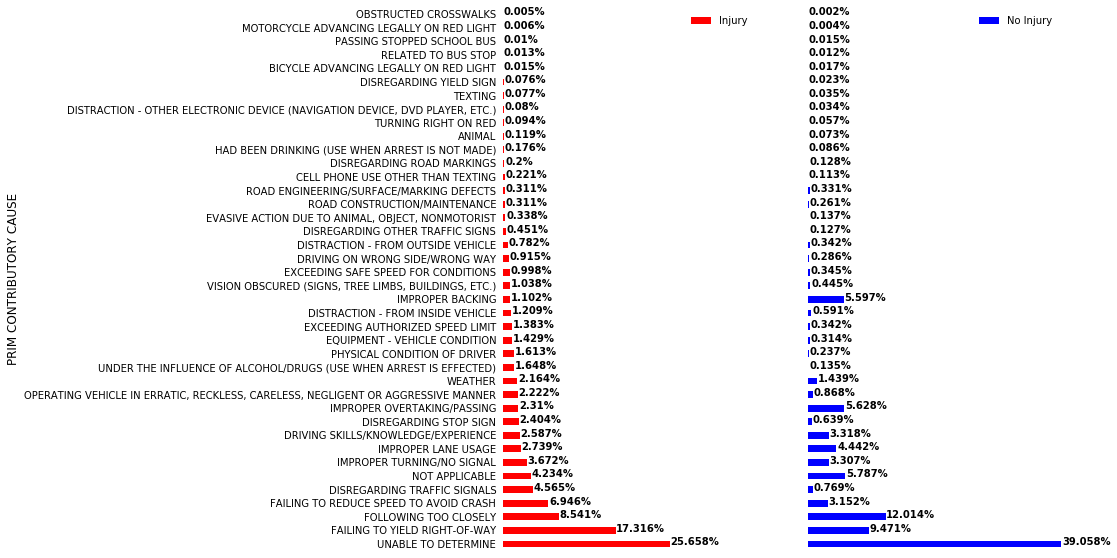

In [32]:
plot_percentages(crashes, "PRIM_CONTRIBUTORY_CAUSE", figsize=(10,10))

Similarly to the feature of collision type, we see a noticeable difference in the distribution of each crash type. We notice how the following causes: failing to yield the right of way, failing to reduce speed, and disregarding traffic signals or stop sign contribute more to injury crashes. On the other hand, improper backing and overtaking or following too closely contribute less to crashes with injury.

By comparing how each type of crash distributes across the different categories of each feature, we notice a great difference in the crash distributions with the two following features: contributory causes and first collision type. In particular, we notice that behaviors such as disregarding traffic signal or failing to reduce speed or not giving the right-of-way, as well as collision types such as angle or turning or pedestrian collisions, are all factors that contributed more in percentage to crashes with injury. With the remaining features, we figure out some slight differences between the two types of crashes. We find that the following factors: higher speed streets, the presence of traffic signal or stop sign, raining weather, darkness, are all factors that contributed slightly more in percentage to crashes with injury. On the other hand, theses crashes happened less with parked cars, and when the first collision is sideswipe in the same direction.

Before we examine how much statically significant these differences are, we check how the number of crashes is changing with time, as well as with the days and hours of the week.  

### Change of Crashes Across Time

We are now interested in examining the presence of any trend in the occurrence of Chicago crashes through time. we plot how the number of each type of crashes is changing from month to month over the years, by counting the number of crashes that happened during each month. 

In [33]:
# Count the number of crashes of each month
crashes.CRASH_DATE = pd.to_datetime(crashes.CRASH_DATE)
crashes["CRASH_MY"] = crashes.CRASH_DATE.apply(
    lambda x: pd.to_datetime(str(datetime.date(x.year, x.month, 1))))
trend = crashes.groupby(["CRASH_MY"]).CRASH_TYPE.value_counts()
trend = trend.unstack().fillna(0)

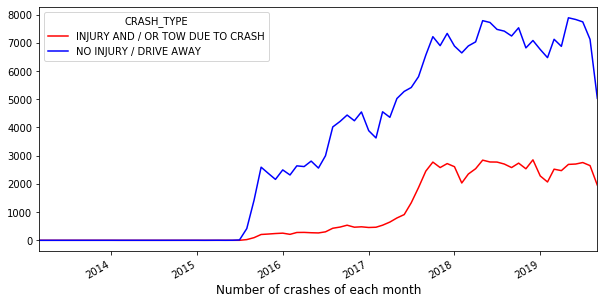

In [34]:
# Plot the time series
trend.plot(figsize=(10, 5), color=['red', 'blue'])
plt.xlabel('Number of crashes of each month', fontsize=12)
plt.show()

We see that starting from to 2017, the number of crashes reported increased this is because data from E-Crash are available for some police districts in 2015, but citywide data are not available until September 2017 (according to the website of Chicago city). We now plot the change in number of crashes starting from September 2017 till August 2019.

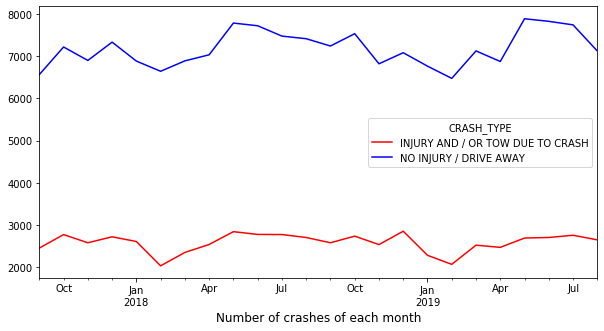

In [35]:
# Plot the time series
t = trend.loc['2017-09':'2019-08', :]
t.plot(figsize=(10, 5), color=['red', 'blue'])
plt.xlabel('Number of crashes of each month', fontsize=12)
plt.show()

Both types of crashes exhibit similar behavior across the months. Interestingly, both types of crashes decrease in February and then increase again during summer. We now check to see if there are any specific hours of the week where more crashes occur. For this sake, we plot how the number of each type of crashes varies across the hours of each day of the week. 

In [36]:
# Compute the total number of crashes per day and hour
crashes_subset = crashes.loc[np.logical_and(
    crashes.CRASH_MY >= '2017-09', crashes.CRASH_MY <= '2019-08'), 
                             ['CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_TYPE']]
cdH = crashes_subset.groupby(['CRASH_DAY_OF_WEEK', 'CRASH_HOUR'])[
    'CRASH_TYPE'].value_counts().sort_index()
cdH = cdH.unstack()
cdH = cdH.reset_index('CRASH_HOUR')

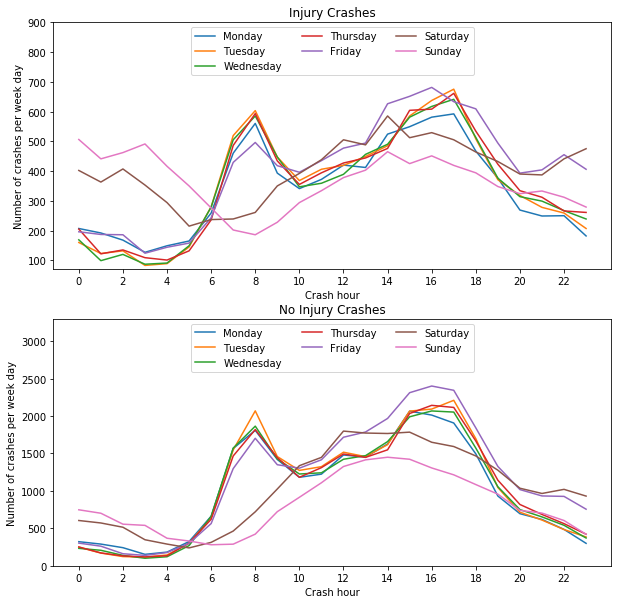

In [37]:
# plot for each type of crashes the change in crash numbers across the hours of each day
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
axes[0].plot( "CRASH_HOUR", "INJURY AND / OR TOW DUE TO CRASH" , data=cdH.loc[2],  label="Monday")
axes[0].plot( "CRASH_HOUR", "INJURY AND / OR TOW DUE TO CRASH" , data=cdH.loc[3],  label="Tuesday")
axes[0].plot( "CRASH_HOUR", "INJURY AND / OR TOW DUE TO CRASH" , data=cdH.loc[4],  label="Wednesday")
axes[0].plot( "CRASH_HOUR", "INJURY AND / OR TOW DUE TO CRASH" , data=cdH.loc[5],  label="Thursday")
axes[0].plot( "CRASH_HOUR", "INJURY AND / OR TOW DUE TO CRASH" , data=cdH.loc[6],  label="Friday")
axes[0].plot( "CRASH_HOUR", "INJURY AND / OR TOW DUE TO CRASH" , data=cdH.loc[7],  label="Saturday")
axes[0].plot( "CRASH_HOUR", "INJURY AND / OR TOW DUE TO CRASH" , data=cdH.loc[1],  label="Sunday")
axes[0].set_xticks(range(0,23,2))
axes[0].set_ylim([70,900])
axes[0].set_ylabel('Number of crashes per week day')
axes[0].set_xlabel("Crash hour")
axes[0].set_title("Injury Crashes")
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=3)

axes[1].plot( "CRASH_HOUR", "NO INJURY / DRIVE AWAY" , data=cdH.loc[2],  label="Monday")
axes[1].plot( "CRASH_HOUR", "NO INJURY / DRIVE AWAY" , data=cdH.loc[3],  label="Tuesday")
axes[1].plot( "CRASH_HOUR", "NO INJURY / DRIVE AWAY" , data=cdH.loc[4],  label="Wednesday")
axes[1].plot( "CRASH_HOUR", "NO INJURY / DRIVE AWAY" , data=cdH.loc[5],  label="Thursday")
axes[1].plot( "CRASH_HOUR", "NO INJURY / DRIVE AWAY" , data=cdH.loc[6],  label="Friday")
axes[1].plot( "CRASH_HOUR", "NO INJURY / DRIVE AWAY" , data=cdH.loc[7],  label="Saturday")
axes[1].plot( "CRASH_HOUR", "NO INJURY / DRIVE AWAY" , data=cdH.loc[1],  label="Sunday")
axes[1].set_xticks(range(0,23,2))
axes[1].set_ylim([0, 3300])
axes[1].set_ylabel('Number of crashes per week day')
axes[1].set_xlabel("Crash hour")
axes[1].set_title("No Injury Crashes")
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=3)
plt.show()

We see that for both types of crashes, during any business day (Monday to Friday), the number of crashes increases in the morning between 7 and 8 am and in the afternoon during the rush hours. During the weekend, for both of type of crashes we see decrease in the number of crashes in the morning at around 7 to 8 am and then an increase in the number of crashes at around 2 pm. We also notice that during the early hours of the day (around 2-3 am), for both types of crashes, the number of crashes during the weekend is higher than that during any business day. However, with injury crashes, we see peaks in the number of crashes at around 2-3 am that are close (in value) to the peaks of some normal business days during the morning and afternoon rush hours. On the other hand, with no injury crashes, we do not see peaks after midnight during the weekend.

After having examined through data visualization the presence of any possible relationship between crash type and crash features, we now test how much this association is statistically significant.

### Measures of Association between Crash Type and Crash Features
We now statically explore the association between crash type and each crash feature. One way to test the association between categorical variables is to perform the chi-square test. However, this type of test is very sensitive to sample size, and might not help in clarifying the strength of the association between crash type and each crash feature. To gain more insight into the relationship between crash type and each feature, we can compute other measures of association that are based on the chi-square test statistic, namely, Cramer's V & Contingency Coefficients. 

We first briefly explain the chi-square test and the measures of association, we then apply them on our data.

#### Brief Explanation of Contingency Table Chi-Square Test and the Measures of Association
To test whether there is an association or not between each crash feature and the crash type, we use contingency table chi-square test. This test considers the following null and alternate hypotheses:
- Null hypothesis $H_0$: A given crash feature has no effect on the crash type;
- Alternate hypothesis $H_a$: A given crash feature has an effect on the crash type.

Given a specific crash feature, the test is performed by first building a table consisting of the numbers of each crash type (Injury or No Injury) observed for each category of the feature, i.e. a cross-tabulation for the crash type and the crash feature. The observed value of each subgroup is then compared with the expected value we could have obtained if the null hypothesis were true. The null hypothesis assumes that the considered crash feature and the crash type are independent. Therefore, under the null hypothesis, the expected value for each category is computed by assuming that the probability of a crash with injury given any category of the feature is the same as the overall probability of a crash with injury, and the probability of a crash with no injury given any category of the feature is the same as the overall probability of a crash with no injury. After having computed the expected ($E_i$) and observed ($O_i$) numbers of crashes for each subgroup, the following test statistic is computed: $$\chi^2=\sum_i\frac{(O_i-E_i)^2}{E_i}$$ This test statistic follows a chi-square distribution, which is used to compute the probability of obtaining a value for the statistic as extreme as the observed one (p-value). If the p-value is small enough, we reject the null hypothesis. 

In this report, in order to perform the chi-square test, we use the following two functions: crosstab() from pandas and chi2_contingency() from scipy.stats. The first functions builds the cross-tabulation between a given crash feature and the crash type. The second function performs the chi-square test on the tabulated data and returns the test statistic and its p-value. 

One limitation of this test is that with large sample size, the test statistic tends to be large and therefore the p-value tends to be low. Therefore, the chi-square test might not be insightful in this case. To gain more insight into the relationship between crash type and each feature, we can compute, using the chi-square test statistic, two measures of association: Cramer's V (with bias correction) and Contingency coefficients. Both can take values between 0 and 1, where a value close to 0 means little or no association and a value close to 1 means strong association. For details on how to compute each coefficient, check the following links: http://uregina.ca/~gingrich/ch11a.pdf, http://stats.lse.ac.uk/bergsma/pdf/cramerV3.pdf, https://www.statisticshowto.datasciencecentral.com/contingency-coefficient/, https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/correlation-coefficient-formula/#cramers%20v%20correlation

To find these coefficients, we have already defined the function that we are going to use to compute Cramer's V (with bias correction) and contingency coefficients.

#### Statistical Analysis of Crash Features and Crash Type
We now perform the chi-square test and compute the association coefficients for each feature and summarize all the results in one table.

In [38]:
# Crash Features
colnames = ["POSTED_SPEED_LIMIT", "TRAFFIC_CONTROL_DEVICE", "WEATHER_CONDITION",
            "LIGHTING_CONDITION", "ALIGNMENT", "ROADWAY_SURFACE_COND", "FIRST_CRASH_TYPE",
            "TRAFFICWAY_TYPE", "PRIM_CONTRIBUTORY_CAUSE", "CRASH_HOUR", "CRASH_MONTH",
            "CRASH_DAY_OF_WEEK"]

# Initialize an empty array that will have the results for each feature
values = np.empty(shape=[4, len(colnames)])
col = 0

# Loop over the features and save chi2, pvalue, cramer's v and contingency coefs
for colname in colnames:
    table = pd.crosstab(crashes.CRASH_TYPE, crashes[colname])
    chi2, p, dof, expected = chi2_contingency(table)
    values[0][col] = chi2
    values[1][col] = p
    cramer, cont = cram_cont(chi2, table)
    values[2][col] = cramer
    values[3][col] = cont
    col = col + 1

# Create a dataframe for the results
results = pd.DataFrame(values)
results.columns = colnames
results.rename(index={0: "Chi2", 1: "P-val",
                      2: "Cramer's V", 3: "Contingency"}, inplace=True)
results.T

,Chi2,P-val,Cramer's V,Contingency
POSTED_SPEED_LIMIT,5526.974091,0.000000e+00,0.127317,0.126432
TRAFFIC_CONTROL_DEVICE,5042.775466,0.000000e+00,0.121551,0.120852
WEATHER_CONDITION,1114.805382,2.430987e-235,0.057036,0.057148
LIGHTING_CONDITION,5976.059908,0.000000e+00,0.132488,0.131383
ALIGNMENT,1079.093910,4.501417e-231,0.056187,0.056228
ROADWAY_SURFACE_COND,1398.069338,1.812259e-301,0.064011,0.063971
FIRST_CRASH_TYPE,42802.004389,0.000000e+00,0.354616,0.334282
TRAFFICWAY_TYPE,9424.847866,0.000000e+00,0.166278,0.164178
PRIM_CONTRIBUTORY_CAUSE,31811.905386,0.000000e+00,0.305592,0.292414
CRASH_HOUR,6731.173747,0.000000e+00,0.140416,0.139285


As expected, we notice how the chi-square statistic is large for all of the features, which makes its corresponding p-values very low. The Cramer's V and contingency coefficients provide a better picture of the association between each crash feature and crash type. We first see that the Cramer's V and contingency coefficients show similar values. Moreover, we notice the following:
- collision type and contributory cause have the two highest Cramer's V coefficient (0.354616 and 0.305592 respectively). This result is consistent with the visualizations where with these two features, we noticed the greater differences in the distribution of each crash type; 
- trafficway type (0.166278) comes next, then hour (0.140416), light, speed and device (0.132488, 0.127317, 0.121551 respectively). These features have similar Cramer's V values and reflect the possible presence of an association between these features and the crash type;
- weather conditions, road surface condition, road alignment, day and month are the features with lowest Cramer's V, which might imply weaker relationship between those features and the crash type.

#### Association between the Features
We now look for any association between the features by computing the Cramer's V coefficient and plot the result in a heatmap.

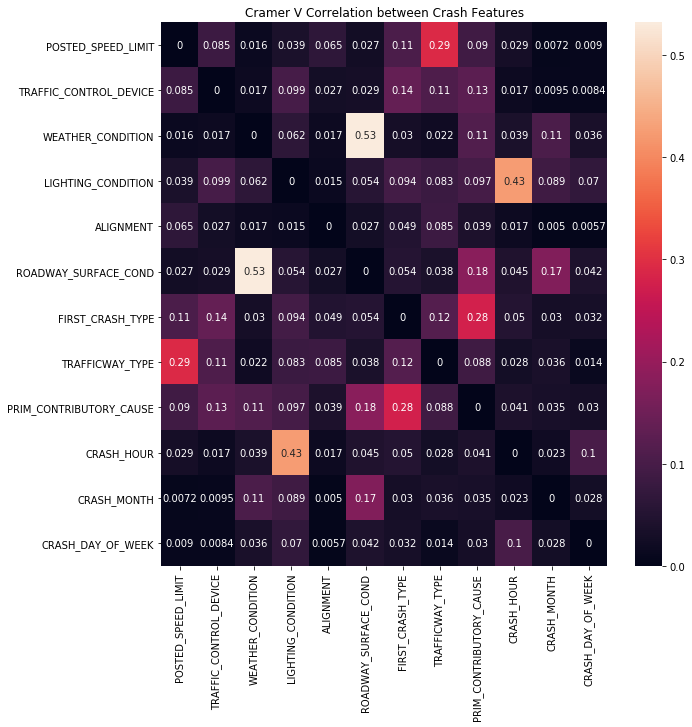

In [39]:
import itertools

corrM = np.zeros((len(colnames), len(colnames)))

for col1, col2 in itertools.combinations(colnames, 2):
    idx1, idx2 = colnames.index(col1), colnames.index(col2)
    table = pd.crosstab(crashes[col1], crashes[col2])
    corrM[idx1, idx2] = cram_cont(chi2_contingency(table)[0], table)[0]
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=colnames, columns=colnames)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr, annot=True, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title("Cramer V Correlation between Crash Features")
plt.show()

We see a strong association between lighting condition and crash hour which is expected since whether there is light or darkness is related to the crash hour. We also see a strong association between weather condition and roadway surface condition, which is also expected since whether the road is wet or dry is related to whether it is clear or raining.

After having examined the association between crash type and each crash feature, we now move to spatial analysis of crashes, in order to see if there is any spatial patterns in the occurrence of Chicago crashes.

### Crashes on Chicago Map
We are now interested in checking the locations of Chicago crashes to see if there is any spatial patterns for injury and no injury crashes, and if there are any places that are more prone to crashes with injury. 

#### Points Locations of Chicago Crashes
We first show the map of the locations of each type of Chicago crashes (point plot). Using the geojson file of Chicago city boundaries from this [website](https://www.chicago.gov/city/en/depts/doit/dataset/boundaries_-_city.html), we create a dataframe that represents the boundaries of Chicago city. 

In [41]:
df = gpd.read_file('chicago.geojson')

We create the points for the injury and no injury crashes using their latitude and longitude information.

In [46]:
# Add the points from the latitude and longitude information to crashes
crashes = gpd.GeoDataFrame(crashes, geometry=[Point(
    xy) for xy in zip(crashes['LONGITUDE'], crashes['LATITUDE'])])

In [47]:
# Divide the crashes according to their type
gdf_injury = crashes.loc[crashes.CRASH_TYPE == 'INJURY AND / OR TOW DUE TO CRASH']
gdf_no_injury = crashes.loc[crashes.CRASH_TYPE != 'INJURY AND / OR TOW DUE TO CRASH']

We now plot Chicago crashes with the locations of each type of crashes.

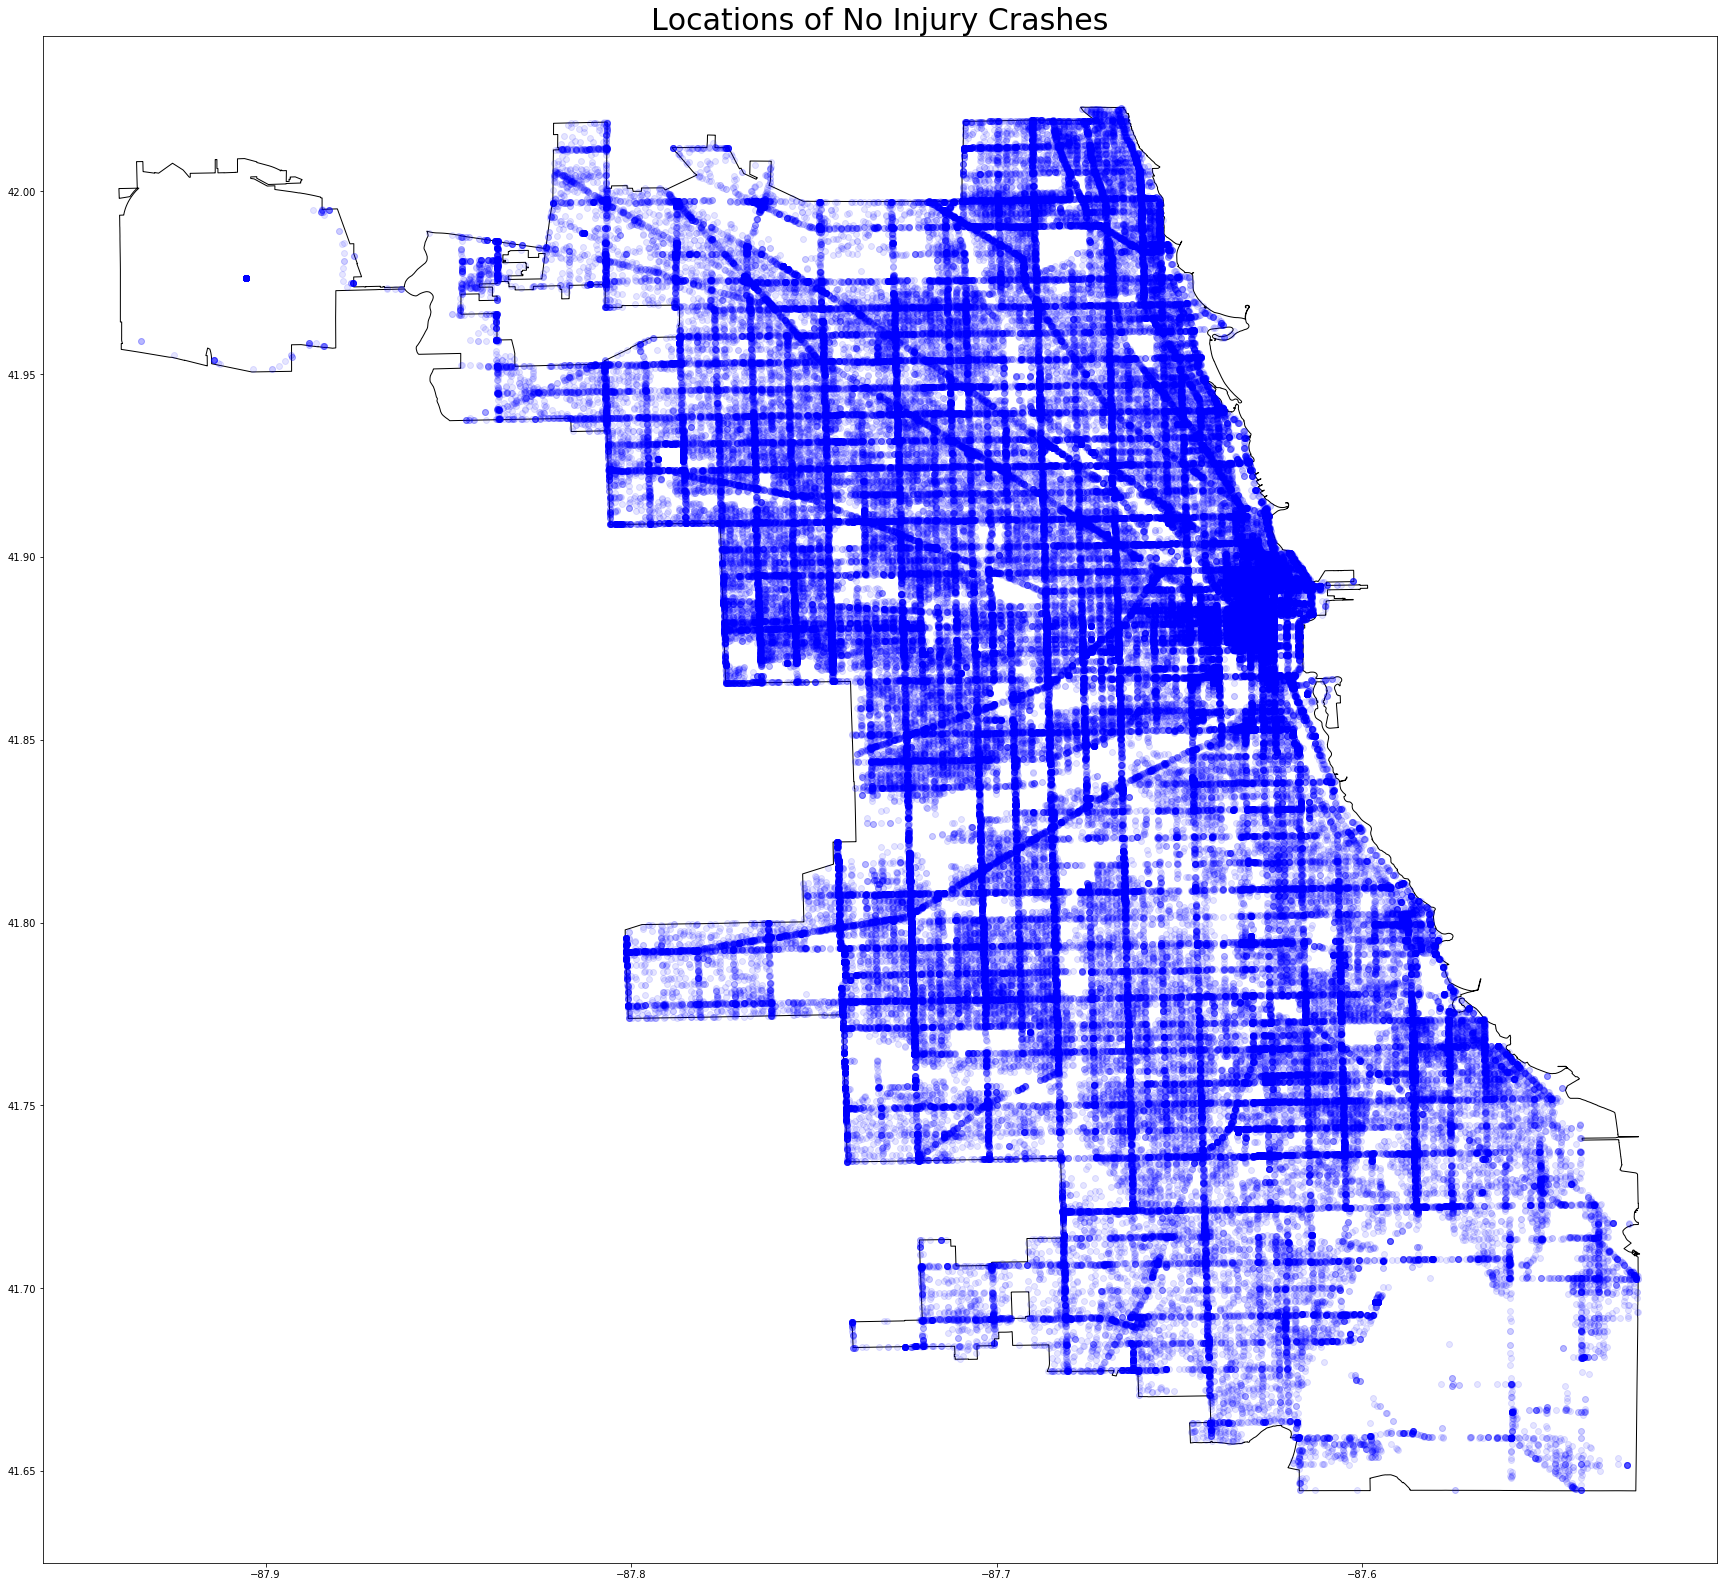

In [48]:
ax = df.plot(figsize=(30, 30), color='white', edgecolor='black')
gdf_no_injury.plot(ax=ax, color='blue', alpha=0.1)
ax.set_title("Locations of No Injury Crashes", fontsize=30)
plt.show()

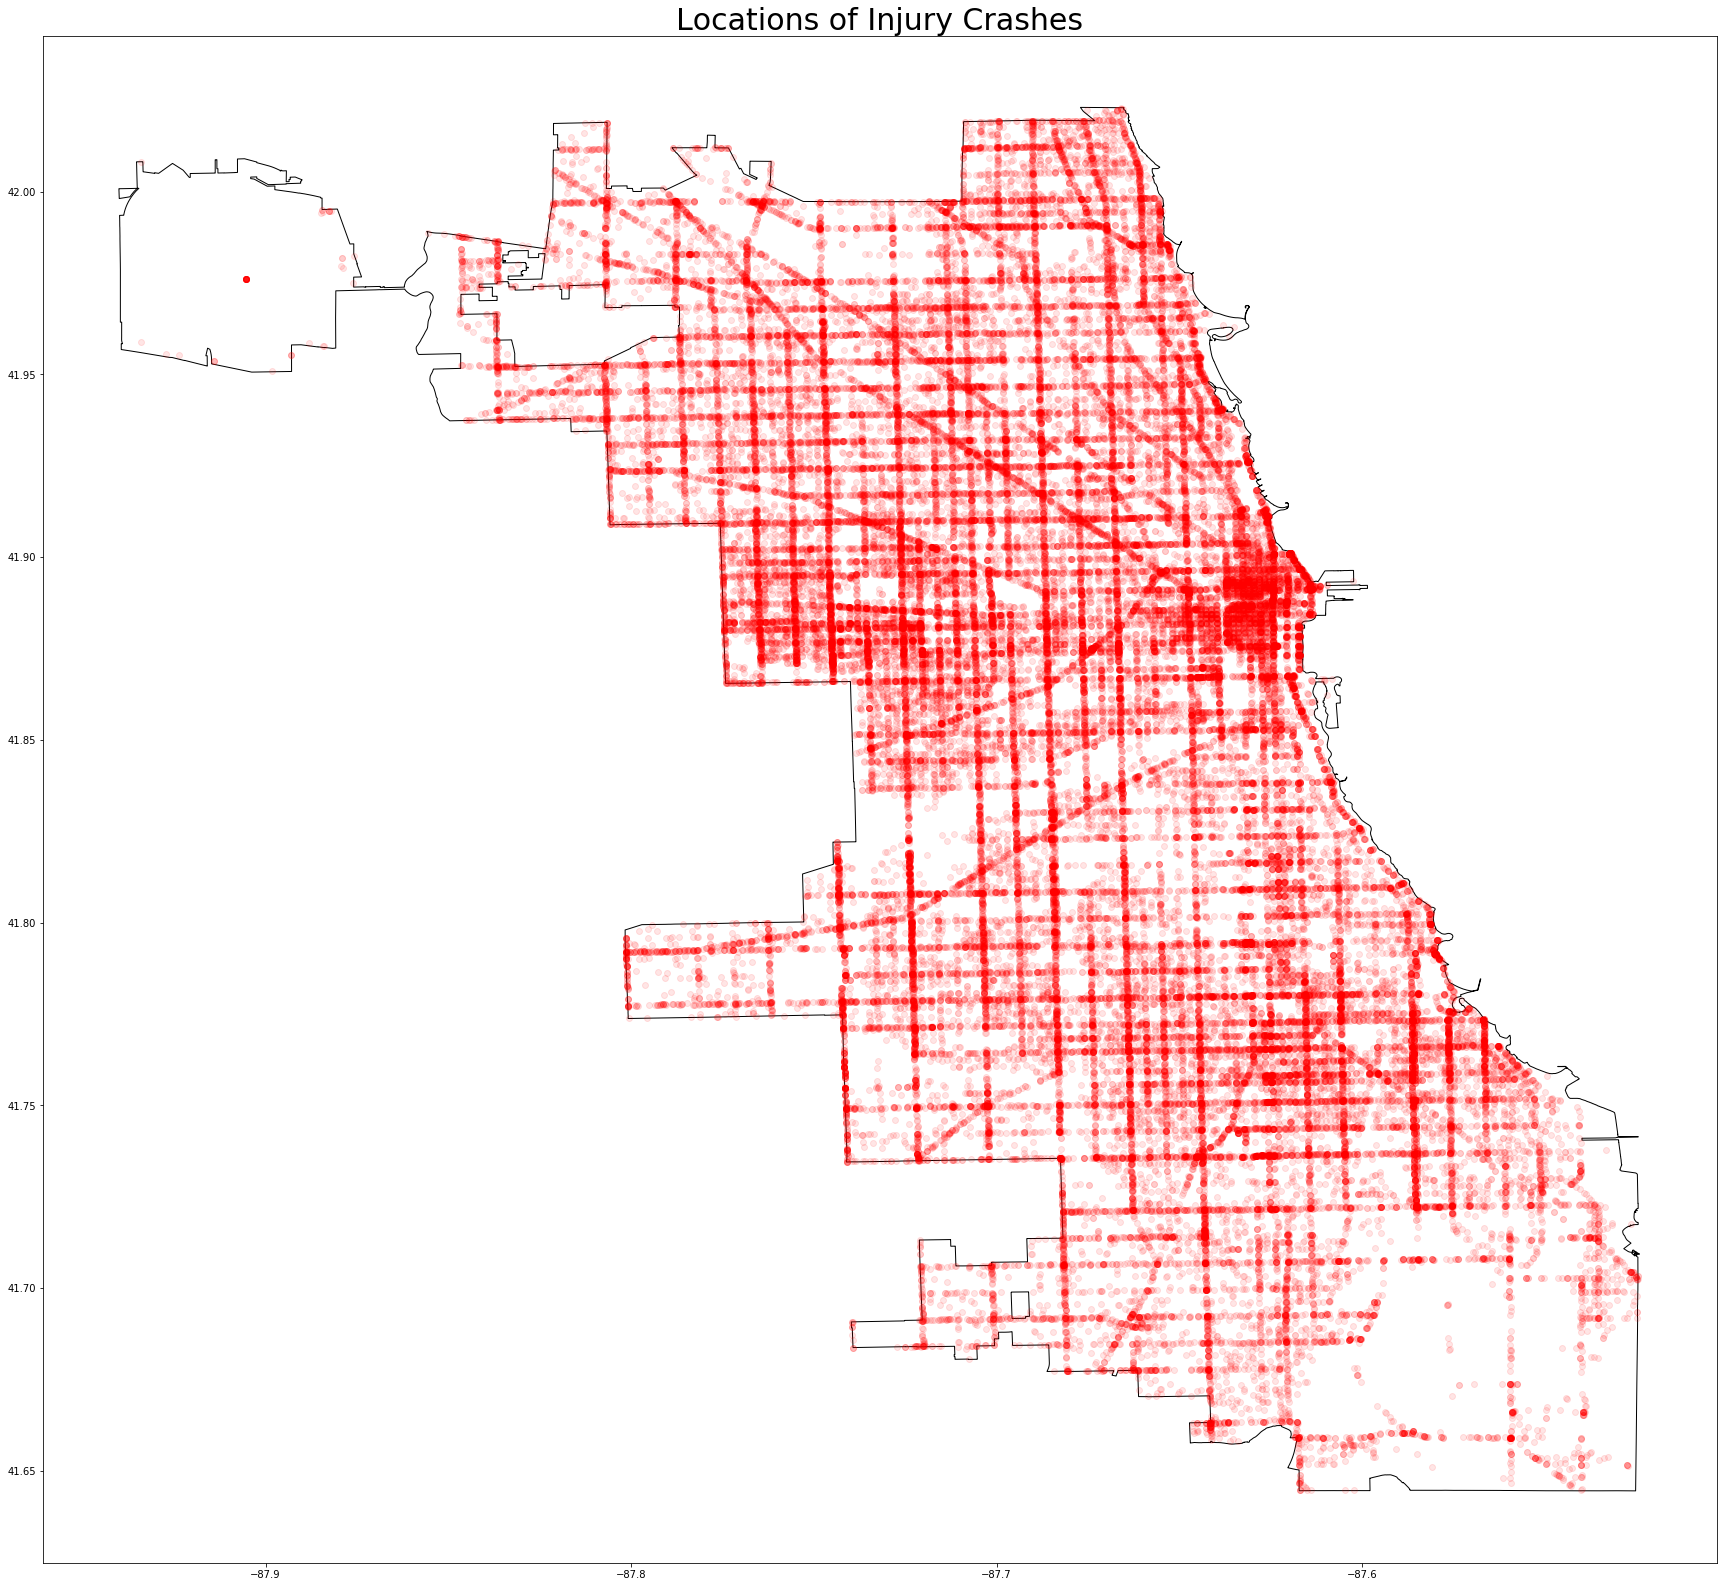

In [49]:
ax = df.plot(figsize=(30, 30), color='white', edgecolor='black')
gdf_injury.plot(ax=ax, color='red', alpha=0.1)
ax.set_title("Locations of Injury Crashes", fontsize=30)
plt.show()

From the two maps, we see that for both types of crashes, many of them were focused in the downtown area of Chicago. However, it is hard to catch any pattern from the pointplot. To gain better understanding of the distribution of the locations of each crash type, we can plot the kernel density estimation for each crash type. This technique estimates the distribution functions for the locations of each crash type.

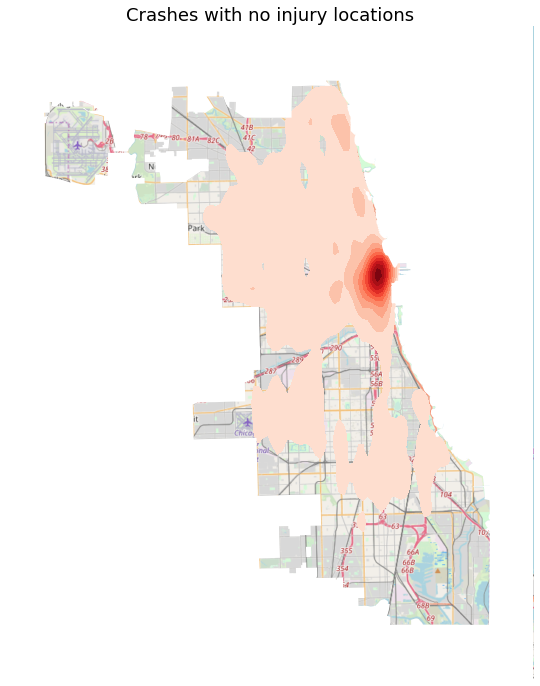

In [50]:
ax = gplt.kdeplot(gdf_no_injury, cmap='Reds', projection=gcrs.WebMercator(), figsize=(12, 12),
                  shade=True, clip=df.geometry)
gplt.webmap(gdf_no_injury, ax=ax)
plt.title('Crashes with no injury locations', fontsize=18)
fig = plt.gcf()
plt.show()

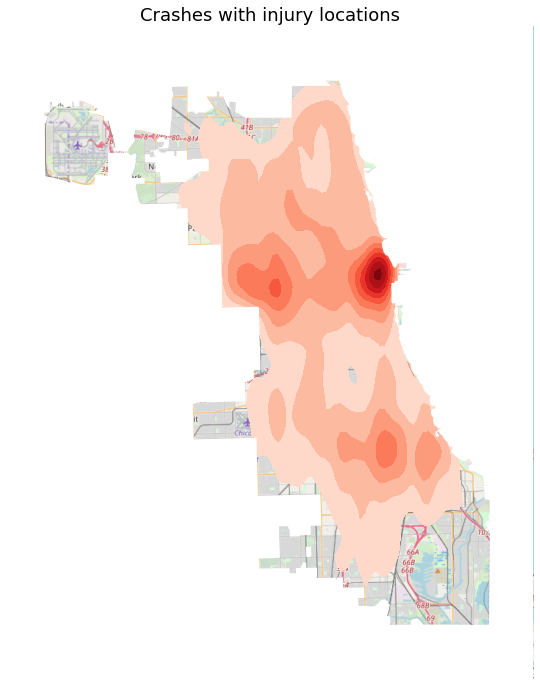

In [51]:
ax2 = gplt.kdeplot(gdf_injury, cmap='Reds', projection=gcrs.WebMercator(), figsize=(12, 12),
                   shade=True, clip=df.geometry)
gplt.webmap(gdf_injury, ax=ax2)
plt.title('Crashes with injury locations', fontsize=18)
fig2 = plt.gcf()
plt.show()

We see that crashes with no injury are mostly focused in the downtown area. On the other hand, injury crashes are more spread out, where we see more crashes to the left side of downtown area.

Another way to explore the distribution of crashes locations is to check their distributions with respect to Chicago community areas. 

#### Crash Distribution across Chicago Areas
The city of Chicago is divided into 77 community areas. Using the geojson file from this [website](https://www.bing.com/profile/history?FORM=EDGEHS&fsi=1), we can show these areas on Chicago map.

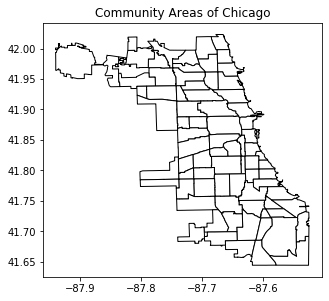

In [52]:
dfc = gpd.read_file('Community.geojson')
ax = dfc.plot(figsize=(5,5),color='white',edgecolor='black')
ax.set_title("Community Areas of Chicago")
plt.show()

Let us see how the crashes of both types are distributed across the community areas of Chicago. For each community area, we count the number of injury and no injury crashes that occurred in the given area and then displays the counts on Chicago map (using choropleth() function).

In [53]:
dfc['Injury'] = 0
dfc['No_Injury'] =0 

for index, row in dfc.iterrows():
    for point in gdf_injury.geometry:
        if (point.within(dfc.loc[index,'geometry'])):
            dfc.at[index,'Injury'] = dfc.loc[index,'Injury'] +1
    for point in gdf_no_injury.geometry:
        if (point.within(dfc.loc[index,'geometry'])):
            dfc.at[index,'No_Injury'] = dfc.loc[index,'No_Injury'] +1  

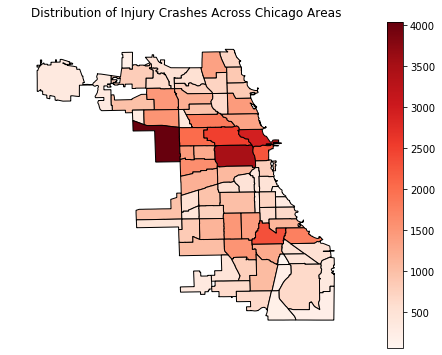

In [54]:
ax = gplt.choropleth(dfc, hue='Injury', cmap='Reds', legend=True)
ax.set_title("Distribution of Injury Crashes Across Chicago Areas")
plt.show()

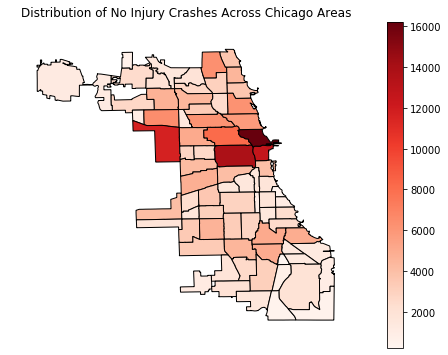

In [55]:
ax = gplt.choropleth(dfc, hue='No_Injury', cmap='Reds', legend=True)
ax.set_title("Distribution of No Injury Crashes Across Chicago Areas")
plt.show()

We see that the highest number of injury crashes is for the west side area of Chicago: "Austin". On the other hand, the highest number of no injury crashes is for the central area: "Near North". We also see that while no injury crashes are more focused in the central part of Chicago, injury crashes are more spread out across the areas. In other words, we notice a relatively high concentration of Chicago crashes in non-central part of Chicago (for instance in the south area: "Great Grand Crossing").

We next analyze whether the observed patterns of the locations of injury crashes are statistically significant (i.e., the map's pattern for injury crashes is not spatially random), by computing some indicators of spatial association or correlation. One example of such indicators is Moran's I statistic, which can be global or local. Global Moran's I can be used to evaluate the similarity, across Chicago areas with respect to the frequency of injury crashes. In other words, are areas with similar frequency of injury crashes located close together or are injury crashes randomly distributed across the areas of Chicago? High values of the Moran’s I imply that there is statistically significant clustering of similar frequencies of crashes across the areas. Low values of Moran’s I imply that there is no statistically significant differences in the frequencies of crashes across the areas. Global Moran's I does not indicate the location of clusters, this is when local Moran's becomes handy.

#### Global Moran's I
Global Moran's indicator provides a single measure of spatial association for the whole area of study. This measure is used to test the hypothesis of the existence of spatial dependency between regions with respect to the variable of interest (in our case, the count or frequency of crashes in Chicago community areas), against the null hypothesis of no (global) spatial association. 
Let us compute the global Moran's I statistic on crashes with injury. For this sake, we use the pysal library.  

In [56]:
import pysal
# Compute the weights for each point
w = pysal.lib.weights.Queen(dfc.geometry)
moran = pysal.explore.esda.Moran(dfc.Injury,w)

C:\Users\User\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [57]:
print(moran.p_sim, moran.z_sim, moran.I)

0.001 5.656101332887506 0.3862738496534036


Since the Moran's I statistic here has low value of p less than 0.05, we conclude that the map's pattern for injury crashes is not spatially random.

#### Local Moran's I
For each community area of Chicago, we can compute a local version of Moran's I, which can be used to test the similarity of the value (here, the number of crashes) of one spatial area with the
values associated with its defined neighborhood. It is also help in identifying any hotspot (clusters of high number of crash occurrence) or coldspot (clusters of low number of crash occurrence).

Let us now check closely the locations of statistically significant clusters using local Moran's I statistic.

In [58]:
np.random.seed(49)
moran_loc = pysal.explore.esda.Moran_Local(dfc.Injury,w)
# Extract significant statistics
sig = moran_loc.p_sim < .05
# find hotspots and coldspots
hotspots = moran_loc.q==1 * sig
coldspots = moran_loc.q==3 * sig

We now plot the locations of hot and cold spots of crashes with injury.

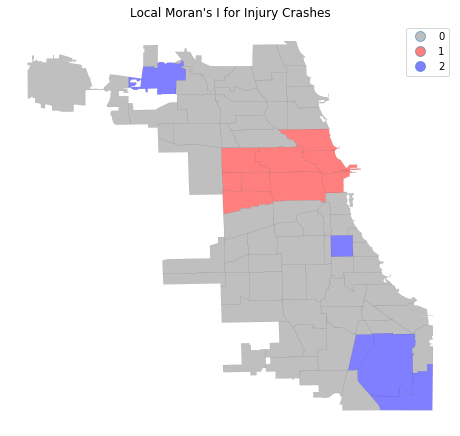

In [59]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(8, 8))
dfc.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, 
        edgecolor='black', legend=True,alpha=0.5)
ax.set_axis_off()
ax.set_title("Local Moran's I for Injury Crashes")
plt.show()

We see a clustering of high number of crashes with injury, in the central part of Chicago. We also notice that that the west side area "Austin" is not highlighted in red (not considered as hot spot), this might be because local Moran's I, when it examines each area, looks for clusters of neighboring areas with similar number of crashes. "Austin" area is surrounded by some areas of low values in crash numbers. 

## Conclusion

We analyzed in this report the traffic crashes of Chicago city. We found that the type of collision and the primary contributory causes of crashes have the strongest association with the crash type. In particular, we noticed that behaviors such as disregarding traffic signal or failing to reduce speed or not giving the right-of-way, as well as collision types such as angle or turning or pedestrian collisions, are all factors that contributed more to crashes with injury. On the other hand, factors such as weather conditions, surface condition of the road and crash month seem to have weaker association with the crash type. Moreover, higher concentration of Chicago crashes are located in the west side and central parts of Chicago.